In [17]:
# Importing libraries
import numpy as np
import pandas as pd

from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.linear_model import Ridge ,LinearRegression
import imblearn
from tqdm import tqdm_notebook
from sklearn.model_selection import KFold,StratifiedKFold ,GroupKFold, cross_val_score
from sklearn.metrics import mean_squared_error, f1_score, confusion_matrix, classification_report, recall_score, precision_recall_fscore_support, precision_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

pd.set_option('max_column', 10000)
pd.set_option('max_row', 10000)

# Plot Packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

import warnings
warnings.filterwarnings('ignore')

In [18]:
import pandas as pd
# Load files
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
sub = pd.read_csv('SampleSubmission.csv')
train.head()

,ID,Year_of_Birth,Education_Level,Marital_Status,Disposable_Income,No_of_Kids_in_home,No_of_Teen_in_home,Date_Customer,Recency,Discounted_Purchases,WebPurchases,CatalogPurchases,StorePurchases,Amount_on_Wines,Amount_on_Fruits,Amount_on_MeatProducts,Amount_on_FishProducts,Amount_on_SweetProducts,Amount_on_GoldProds,WebVisitsMonth,Cmp3Accepted,Cmp4Accepted,Cmp5Accepted,Cmp1Accepted,Cmp2Accepted,Any_Complain,Response
0,ID_4A9AR6FQ,1955,Graduation,Divorced,77504.4,1,1,22-06-2014,56,2,1,1,4,71,3,16,0,6,20,3,0,0,0,0,0,0,0
1,ID_X28T3VEK,1958,Graduation,Together,56784.0,0,1,01-08-2013,17,6,5,1,8,205,22,111,50,15,19,6,0,0,0,0,0,0,0
2,ID_AWXARH57,1962,Graduation,Single,103714.8,0,0,21-11-2013,17,0,7,4,7,469,31,873,29,18,37,2,0,0,0,1,0,0,1
3,ID_FQVZHE81,1979,2n Cycle,Single,46311.6,1,0,13-09-2013,49,3,4,1,3,56,15,49,17,24,24,8,0,0,0,0,0,0,0
4,ID_QVLWGPRN,1959,Graduation,Married,87486.0,0,0,21-01-2014,59,1,3,7,9,412,117,445,181,165,203,1,0,0,0,1,0,0,0


In [19]:
train.isna().sum()

ID                          0
Year_of_Birth               0
Education_Level             0
Marital_Status              0
Disposable_Income          16
No_of_Kids_in_home          0
No_of_Teen_in_home          0
Date_Customer               0
Recency                     0
Discounted_Purchases        0
WebPurchases                0
CatalogPurchases            0
StorePurchases              0
Amount_on_Wines             0
Amount_on_Fruits            0
Amount_on_MeatProducts      0
Amount_on_FishProducts      0
Amount_on_SweetProducts     0
Amount_on_GoldProds         0
WebVisitsMonth              0
Cmp3Accepted                0
Cmp4Accepted                0
Cmp5Accepted                0
Cmp1Accepted                0
Cmp2Accepted                0
Any_Complain                0
Response                    0
dtype: int64

In [20]:
a = train[train['Year_of_Birth']<1940].index
train.drop(a, axis=0, inplace=True)
train.reset_index(drop=True, inplace=True)

In [21]:
len_train = len(train)
data = pd.concat([train, test]).reset_index(drop=True)

In [22]:
data['Disposable_Income'] = data['Disposable_Income'].fillna(train['Disposable_Income'].median())

In [23]:
data['Date_Customer'] = pd.to_datetime(data['Date_Customer'])

data['enrollment_year'] = data['Date_Customer'].dt.year
data['enrollment_month'] = data['Date_Customer'].dt.month
data['enrollment_day'] = data['Date_Customer'].dt.day

In [24]:
data.head()

,ID,Year_of_Birth,Education_Level,Marital_Status,Disposable_Income,No_of_Kids_in_home,No_of_Teen_in_home,Date_Customer,Recency,Discounted_Purchases,WebPurchases,CatalogPurchases,StorePurchases,Amount_on_Wines,Amount_on_Fruits,Amount_on_MeatProducts,Amount_on_FishProducts,Amount_on_SweetProducts,Amount_on_GoldProds,WebVisitsMonth,Cmp3Accepted,Cmp4Accepted,Cmp5Accepted,Cmp1Accepted,Cmp2Accepted,Any_Complain,Response,enrollment_year,enrollment_month,enrollment_day
0,ID_4A9AR6FQ,1955,Graduation,Divorced,77504.4,1,1,2014-06-22,56,2,1,1,4,71,3,16,0,6,20,3,0,0,0,0,0,0,0.0,2014,6,22
1,ID_X28T3VEK,1958,Graduation,Together,56784.0,0,1,2013-01-08,17,6,5,1,8,205,22,111,50,15,19,6,0,0,0,0,0,0,0.0,2013,1,8
2,ID_AWXARH57,1962,Graduation,Single,103714.8,0,0,2013-11-21,17,0,7,4,7,469,31,873,29,18,37,2,0,0,0,1,0,0,1.0,2013,11,21
3,ID_FQVZHE81,1979,2n Cycle,Single,46311.6,1,0,2013-09-13,49,3,4,1,3,56,15,49,17,24,24,8,0,0,0,0,0,0,0.0,2013,9,13
4,ID_QVLWGPRN,1959,Graduation,Married,87486.0,0,0,2014-01-21,59,1,3,7,9,412,117,445,181,165,203,1,0,0,0,1,0,0,0.0,2014,1,21


In [25]:
from sklearn.preprocessing import LabelEncoder
cat_col = ['Education_Level','Marital_Status']

for i in cat_col:
    le = LabelEncoder()
    data[i] = le.fit_transform(data[i])


In [26]:
data.head(10)

,ID,Year_of_Birth,Education_Level,Marital_Status,Disposable_Income,No_of_Kids_in_home,No_of_Teen_in_home,Date_Customer,Recency,Discounted_Purchases,WebPurchases,CatalogPurchases,StorePurchases,Amount_on_Wines,Amount_on_Fruits,Amount_on_MeatProducts,Amount_on_FishProducts,Amount_on_SweetProducts,Amount_on_GoldProds,WebVisitsMonth,Cmp3Accepted,Cmp4Accepted,Cmp5Accepted,Cmp1Accepted,Cmp2Accepted,Any_Complain,Response,enrollment_year,enrollment_month,enrollment_day
0,ID_4A9AR6FQ,1955,2,2,77504.4,1,1,2014-06-22,56,2,1,1,4,71,3,16,0,6,20,3,0,0,0,0,0,0,0.0,2014,6,22
1,ID_X28T3VEK,1958,2,5,56784.0,0,1,2013-01-08,17,6,5,1,8,205,22,111,50,15,19,6,0,0,0,0,0,0,0.0,2013,1,8
2,ID_AWXARH57,1962,2,4,103714.8,0,0,2013-11-21,17,0,7,4,7,469,31,873,29,18,37,2,0,0,0,1,0,0,1.0,2013,11,21
3,ID_FQVZHE81,1979,0,4,46311.6,1,0,2013-09-13,49,3,4,1,3,56,15,49,17,24,24,8,0,0,0,0,0,0,0.0,2013,9,13
4,ID_QVLWGPRN,1959,2,3,87486.0,0,0,2014-01-21,59,1,3,7,9,412,117,445,181,165,203,1,0,0,0,1,0,0,0.0,2014,1,21
5,ID_3S3HRGH6,1960,3,3,41090.4,0,1,2014-03-23,32,1,0,0,3,13,5,4,0,0,1,5,0,0,0,0,0,0,0.0,2014,3,23
6,ID_KJQ9B2LE,1953,2,4,86673.6,0,0,2012-11-27,94,1,6,7,8,636,31,491,30,14,56,3,0,0,0,0,0,0,0.0,2012,11,27
7,ID_6O0NBZXD,1974,2,5,88711.2,0,0,2013-02-03,61,1,6,5,12,632,94,597,159,91,15,3,0,0,0,0,0,0,0.0,2013,2,3
8,ID_M3QFT8WO,1966,2,5,35606.4,1,1,2013-12-03,13,1,0,0,3,14,4,3,0,4,8,6,0,0,0,0,0,0,0.0,2013,12,3
9,ID_745JV5PY,1975,2,3,41305.2,1,0,2013-01-07,88,1,1,0,2,8,6,7,6,2,9,7,0,0,0,0,0,0,0.0,2013,1,7


In [27]:
train = data[:len_train]
test = data[len_train:]

In [28]:
X = train.drop(columns=['ID','Date_Customer','Response'])
y = train['Response']
tes = test.drop(columns=['ID','Date_Customer','Response'])

In [29]:
y.value_counts()

0.0    1328
1.0     239
Name: Response, dtype: int64

<AxesSubplot:ylabel='Response'>

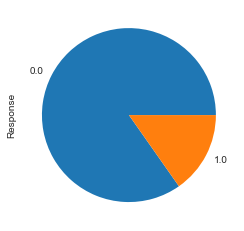

In [30]:
y.value_counts().plot(kind='pie')

In [31]:
from imblearn.over_sampling import SMOTE
seed = 50
sm = SMOTE(sampling_strategy={1:280, 0:1328}, random_state=seed) 
X_, y_ = sm.fit_resample(X, y)

In [54]:
#importing required ML packages
%time
from sklearn.ensemble import RandomForestClassifier #Random forest
folds = KFold(n_splits=5, shuffle=True, random_state=1234)
oofs = np.zeros((len(X_)))
preds = np.zeros((len(tes)))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_, y_)):
    
    X_trn, y_trn = X_.iloc[trn_idx], y_.iloc[trn_idx]
    X_val, y_val = X_.iloc[val_idx], y_.iloc[val_idx]
    
    
    clf = LGBMClassifier(learning_rate=0.2, n_estimators=1000, scale_pos_weight=4, max_depth=-1, 
                         colsample_bytree=0.7, subsample=0.85, reg_alpha=3, reg_lambda=20)
    clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)],
                    verbose = 0, early_stopping_rounds=200)
    
    vp = clf.predict_proba(X_val)[:,1]
    b = pd.DataFrame(vp)
    b[0] = np.where(b[0]>0.5, 1, 0)
    val_score = f1_score((y_val), (b[0]))
    
    print(f'\nFold {fold_+1} Val score: {val_score}\n')
    
    tp = clf.predict_proba(tes)[:,1]
    
    oofs[val_idx] = vp
    preds += tp/5
    
a = pd.DataFrame(oofs)
a[0] = np.where(a[0]>0.5, 1, 0)
oof_score = f1_score((y_), (a[0]))
print(f'\nOOF F1 score is : {oof_score}')

Wall time: 0 ns

Fold 1 Val score: 0.6722689075630253


Fold 2 Val score: 0.689655172413793


Fold 3 Val score: 0.6470588235294118


Fold 4 Val score: 0.6181818181818182


Fold 5 Val score: 0.723076923076923


OOF F1 score is : 0.6724436741767764


In [55]:
folds.split

<bound method _BaseKFold.split of KFold(n_splits=5, random_state=1234, shuffle=True)>

In [56]:
sub['Response'] = preds

In [57]:
sub.head()

,ID,Response
0,ID_ZPMABNVX,0.075586
1,ID_WFE91NAA,0.399758
2,ID_JV11RBRK,0.027466
3,ID_6B7SVKY9,0.584636
4,ID_GOVUZ545,0.150991


In [58]:
sub['Response'] = np.where(sub['Response'] >= 0.5, 1, 0)

In [59]:
sub['Response'].value_counts()

0    562
1    110
Name: Response, dtype: int64

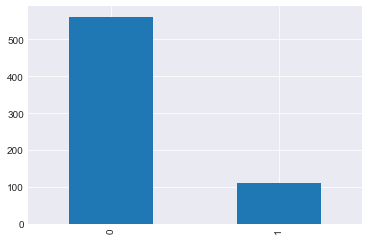

In [62]:
#Visualization of the response
sub['Response'].value_counts().plot(kind='bar');

In [63]:
sub.to_csv('my_sub.csv', index=False)